# Test MCMC_sampling to learn norms from a data
The experiment has two components at the highest level:
1. Generating the data from which MCMC would approximate posterior distributuion
2. Generating the sequence of learned norms from MCMC

## 1. Generating Data for MCMC

In [42]:
from environment import *
from rules_3 import *
from robot_task_new import *
from algorithm_1 import create_data

from copy import deepcopy
from numpy import nan
import matplotlib.pyplot as plt
import time

### Let us first initialise the env and the norms

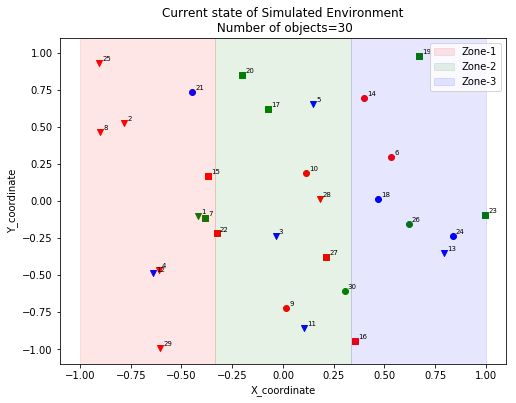

In [24]:
env=create_env(N=30)
fig,ax=plt.subplots(figsize=(8,6))
plot_env(env,ax,legend=True)

In [19]:
expression=expand("NORMS")
print_expression(expression)

------------------------------------------------
                NORM Number=1
------------------------------------------------
   > OBLIGATORY to
     PUTDOWN G-CIRCLEs in ZONE-3
     if you PICKUP G-CIRCLEs
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     G-CIRCLEs in ZONE-1


### Let's define a task and perform it repeatitively to generate the data
The task is to clear the target area of ***every-circle***

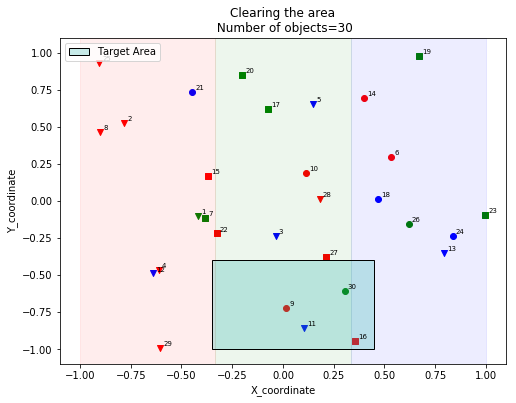

In [49]:
target_area=[position(-0.35,-1),position(0.45,-0.4)]
task1=task(colour_specific='g',shape_specific="circle",target_area=target_area)
fig,ax=plt.subplots(figsize=(8,6))
plot_task(env,ax,"Clearing the area",task1,True)

In [50]:
s=time.time()
action_profile_with_norms=create_data(task1,expression,env,"with_norms",num_repeat=500,verbose=False)
print ("Time Taken to complete job={:.2f}s\n".format(time.time()-s))
s=time.time()
action_profile_wo_norms=create_data(task1,[],env,"wo_norms",num_repeat=500,verbose=False)
print ("Time Taken to complete job={:.2f}s".format(time.time()-s))

Generating for case with_norms
Time Taken to complete job=283.09s
Generating for case wo_norms
Time Taken to complete job=220.21s


In [51]:
data_with_norms=[]
for itr,ap in action_profile_with_norms.items():
    for i in range(0,int(len(ap)/2)):
        data_with_norms.append(tuple([ap[2*i],ap[2*i+1]]))
print ("Data with norms")
for i in range(5):
    print(data_with_norms[i]) 

data_wo_norms=[]
for itr,ap in action_profile_wo_norms.items():
    for i in range(0,int(len(ap)/2)):
        data_wo_norms.append(tuple([ap[2*i],ap[2*i+1]]))
print ("\nData without norms")
for i in range(5):
    print(data_wo_norms[i])

Data with norms
(('pickup', 30), ('putdown', 30, 3))
(('pickup', 30), ('putdown', 30, 1))
(('pickup', 30), ('putdown', 30, 1))
(('pickup', 30), ('putdown', 30, 3))
(('pickup', 30), ('putdown', 30, 3))

Data without norms
(('pickup', 30), ('putdown', 30, 2))
(('pickup', 30), ('putdown', 30, 3))
(('pickup', 30), ('putdown', 30, 3))
(('pickup', 30), ('putdown', 30, 2))
(('pickup', 30), ('putdown', 30, 3))


## 2. Run MCMC to generate sequence of expressions

In [52]:
from algorithm_1 import algorithm_1,to_tuple

import seaborn as sns
from collections import Counter
import os
import sys

### Generate sequence of expression

In [53]:
s=time.time()
print ("Generating sequence for data with norms")
exp_seq_with,lik_list_with=algorithm_1(data_with_norms,env,q_dict,rule_dict,filename="mcmc_test/mcmc_report_with_norms",max_iterations=50000,testing=True)
print ("Time Taken to complete job={:.2f}s\n".format(time.time()-s))
s=time.time()
print ("Generating sequence for data without norms")
exp_seq_wo,lik_list_wo=algorithm_1(data_wo_norms,env,q_dict,rule_dict,filename="mcmc_test/mcmc_report_without_norms",max_iterations=50000,testing=True)
print ("Time Taken to complete job={:.2f}s\n".format(time.time()-s))

Generating sequence for data with norms
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PICKUP
     R-SQUAREs in ZONE-2
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     G-SQUAREs in ZONE-1
Time Taken to complete job=164.43s

Generating sequence for data without norms
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > OBLIGATORY to
     PUTDOWN R-TRIANGLEs in ZONE-1
     if you PICKUP R-TRIANGLEs
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PICKUP
     B-CIRCLEs in ZONE-2
Time Taken to complete job=144.93s



### See the learned norms in both the cases and plot their frequencies after discarding the warmup

In [54]:
learned_norms_with=Counter(map(to_tuple,exp_seq_with[int(len(exp_seq_with)/2)+1:]))
t_with=sum(learned_norms_with.values())
print ("For data generated with norms:")
print ("Number of unique Norms in sequence={}".format(len(learned_norms_with)))
print ("Order of Improvement in Likelihood={:.2E}".format(max(lik_list_with)/min(lik_list_with)))

For data generated with norms:
Number of unique Norms in sequence=53
Order of Improvement in Likelihood=1.11E+88


In [55]:
learned_norms_wo=Counter(map(to_tuple,exp_seq_wo[int(len(exp_seq_wo)/2)+1:]))
t_wo=sum(learned_norms_wo.values())
print ("For data generated without norms:")
print ("Number of unique Norms in sequence={}".format(len(learned_norms_wo)))
print ("Order of Improvement in Likelihood={:.2E}".format(max(lik_list_wo)/min(lik_list_wo)))

For data generated without norms:
Number of unique Norms in sequence=3824
Order of Improvement in Likelihood=1.00E+00


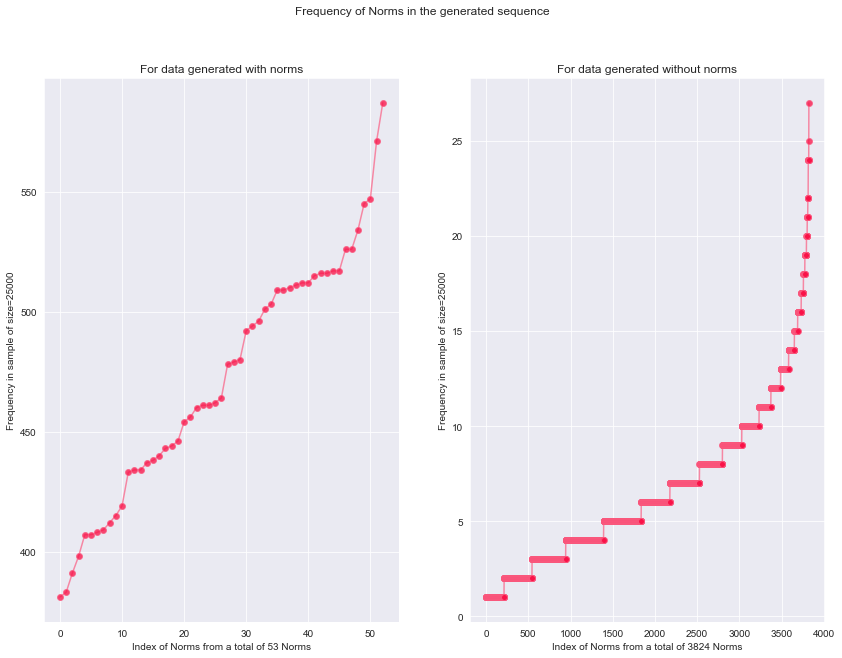

In [56]:
sns.set_style("darkgrid")
fig,ax=plt.subplots(1, 2, sharex=False, sharey=False,figsize=(14,10))
fig.suptitle('Frequency of Norms in the generated sequence')

ax[0].plot(sorted(learned_norms_with.values()),"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[0].set_ylabel("Frequency in sample of size={}".format(t_with))
ax[0].set_xlabel("Index of Norms from a total of {} Norms".format(len(learned_norms_with)))
ax[0].title.set_text("For data generated with norms")

ax[1].plot(sorted(learned_norms_wo.values()),"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[1].set_ylabel("Frequency in sample of size={}".format(t_wo))
ax[1].set_xlabel("Index of Norms from a total of {} Norms".format(len(learned_norms_wo)))
ax[1].title.set_text("For data generated without norms")

### Investigate the top_norms learned from data generated with norms

In [57]:
top=learned_norms_with.most_common()
exists = os.path.isfile('./mcmc_test/top_norms_with_norms.txt')
if exists==True:
    os.remove('./mcmc_test/top_norms_with_norms.txt')
original = sys.stdout
for i in range(len(top)):
    exp=top[i]
    print("Rank:{} Norm has relative frequency={:.3f}%".format(i+1,exp[1]*100/t_with))
    sys.stdout = open('./mcmc_test/top_norms_with_norms.txt', 'a+')
    print("\n\n\n************Rank:{}, %-Frequency={:.3f}%**********".format(i+1,exp[1]*100/t_with))
    print_expression(exp[0])
    print("*************************************************")
    sys.stdout=original

Rank:1 Norm has relative frequency=2.348%
Rank:2 Norm has relative frequency=2.284%
Rank:3 Norm has relative frequency=2.188%
Rank:4 Norm has relative frequency=2.180%
Rank:5 Norm has relative frequency=2.136%
Rank:6 Norm has relative frequency=2.104%
Rank:7 Norm has relative frequency=2.104%
Rank:8 Norm has relative frequency=2.068%
Rank:9 Norm has relative frequency=2.068%
Rank:10 Norm has relative frequency=2.064%
Rank:11 Norm has relative frequency=2.064%
Rank:12 Norm has relative frequency=2.060%
Rank:13 Norm has relative frequency=2.048%
Rank:14 Norm has relative frequency=2.048%
Rank:15 Norm has relative frequency=2.044%
Rank:16 Norm has relative frequency=2.040%
Rank:17 Norm has relative frequency=2.036%
Rank:18 Norm has relative frequency=2.036%
Rank:19 Norm has relative frequency=2.012%
Rank:20 Norm has relative frequency=2.004%
Rank:21 Norm has relative frequency=1.984%
Rank:22 Norm has relative frequency=1.976%
Rank:23 Norm has relative frequency=1.968%
Rank:24 Norm has rel

### Investigate the top_norms learned from data generated without norms

In [58]:
top=learned_norms_wo.most_common()[:20]
exists = os.path.isfile('./mcmc_test/top_norms_wo_norms.txt')
if exists==True:
    os.remove('./mcmc_test/top_norms_wo_norms.txt')
original = sys.stdout
for i in range(len(top)):
    exp=top[i]
    print("Rank:{} Norm has relative frequency={:.3f}%".format(i+1,exp[1]*100/t_wo))
    sys.stdout = open('./mcmc_test/top_norms_wo_norms.txt', 'a+')
    print("\n\n\n************Rank:{}, %-Frequency={:.3f}%**********".format(i+1,exp[1]*100/t_wo))
    print_expression(exp[0])
    print("*************************************************")
    sys.stdout=original

Rank:1 Norm has relative frequency=0.108%
Rank:2 Norm has relative frequency=0.100%
Rank:3 Norm has relative frequency=0.096%
Rank:4 Norm has relative frequency=0.096%
Rank:5 Norm has relative frequency=0.096%
Rank:6 Norm has relative frequency=0.096%
Rank:7 Norm has relative frequency=0.096%
Rank:8 Norm has relative frequency=0.096%
Rank:9 Norm has relative frequency=0.096%
Rank:10 Norm has relative frequency=0.088%
Rank:11 Norm has relative frequency=0.088%
Rank:12 Norm has relative frequency=0.088%
Rank:13 Norm has relative frequency=0.088%
Rank:14 Norm has relative frequency=0.088%
Rank:15 Norm has relative frequency=0.084%
Rank:16 Norm has relative frequency=0.084%
Rank:17 Norm has relative frequency=0.084%
Rank:18 Norm has relative frequency=0.084%
Rank:19 Norm has relative frequency=0.084%
Rank:20 Norm has relative frequency=0.084%
